# Onset detection using Echo State Networks

## Introduction

In this notebook, we demonstrate how the ESN can deal with musical onset detection, detecting the start time of new note events.

As this is a computationally expensive task, we have pre-trained models to serve as an entry point.

At first, we import all packages required for this task. You can find the import statements below.

In [1]:
import numpy as np
import scipy
import os
import csv
from collections import deque
from intervaltree import IntervalTree
from sklearn.base import clone
from joblib import dump, load, Parallel, delayed

from matplotlib import pyplot as plt
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import soundfile as sf
from madmom.utils import quantize_events
from madmom.processors import SequentialProcessor, ParallelProcessor
from madmom.audio import SignalProcessor, FramedSignalProcessor
from madmom.audio.stft import ShortTimeFourierTransformProcessor
from madmom.audio.filters import LogarithmicFilterbank
from madmom.audio.spectrogram import FilteredSpectrogramProcessor, LogarithmicSpectrogramProcessor, SpectrogramDifferenceProcessor

from pyrcn.echo_state_network import ESNRegressor

## Dataset

For training and evaluation, we have used the Böck dataset. Therefore, you need to download three archive: The annotations can be downloaded from ([https://drive.google.com/file/d/0B-MfhNTg9c5eTGJ6X0FOd0xDSWs/view](https://drive.google.com/file/d/0B-MfhNTg9c5eTGJ6X0FOd0xDSWs/view)), the split files can be downloaded from ([https://drive.google.com/file/d/0B-MfhNTg9c5eUV9DRVluNjdTOGs/view](https://drive.google.com/file/d/0B-MfhNTg9c5eUV9DRVluNjdTOGs/view)) and the audio files from ([https://drive.google.com/file/d/0B-MfhNTg9c5eeDktWUpjeUF3VkU/view](https://drive.google.com/file/d/0B-MfhNTg9c5eeDktWUpjeUF3VkU/view)). 

In the following, we assume that you have downloaded and extracted the dataset successfully to the subfolder "dataset/onset_detection". We have prepared the directory structure and one example file "ff123_ATrain.flac" to give you and idea how the dataset should be organized for this notebook.

The dataset is split into folds for 8-fold cross validation. The subdirectory "dataset/onset_detection/onsets_splits" contains eight file lists. Each contains 39 to 41 file names. By default, we have placed one file name in the first file list. The other ones are empty and need to be filled after downloading the datsaet.

We use the following function to return a nested list eight file lists, one for each fold:

In [2]:
def get_splits(onsets_splits_path: str=r"C:\Users\Steiner\Documents\Python\PyRCN\examples\dataset\onset_detection\boeck_dataset\onsets_splits"):
    """
    onsets_splits_path: str: /full/path/to/onsets_splits/
    """
    onsets_splits_path = os.path.normpath(onsets_splits_path)
    folds = []
    for _, _, file_names in os.walk(onsets_splits_path):
        for file_name in sorted(file_names):
            with open(os.path.join(onsets_splits_path, file_name)) as f:
                content = f.readlines()
                content = [x.strip() for x in content]
                folds.append(content)
    return folds

## Prepare an ESN model

We have already trained ESN models with different reservoir sizes in the uni- and bidirectional mode. 

In case you would like to train new models, we provide the code here. Note that this will take a lot of time as the MusicNet is a large-scale dataset. Furthermore, you need to download the dataset at first, as we have just included one audio file for demonstration purposes. 

In [3]:
try:
    esn = load(r"C:\Users\Steiner\Documents\Python\PyRCN\examples\dataset\onset_detection\models\esn_500_bi_delta.joblib")
except:
    esn = ESNRegressor(k_in=10, input_scaling=0.4, spectral_radius=0.5, bias=0.8, leakage=1.0, reservoir_size=500, k_res=10,
                       reservoir_activation='tanh', bi_directional=False, solver='ridge', beta=1e-2, random_state=1)

## Feature extraction

The acoustic features extracted from the input signal are obtained by filtering short-term spectra (window length 4096 samples and hop size 10 ms) with a bank of triangular filters in the frequency domain with log-spaced frequencies. The frequency range was 30 Hz to 17 000 Hz and we used 12 filters per octave. We used logarithmic magnitudes and added 1 inside the logarithm to ensure a minimum value of 0 for a frame without energy. The first derivative between adjacent frames was added in order to enrich the features by temporal information. Binary labels indicating absent (value 0) or present (value 1) pitches for each frame are assigned to each frame. Note that this task is a multilabel classification. Each MIDI pitch is a separate class, and multiple or no classes can be active at a discrete frame index.

In [4]:
def superflux_delta(S, max_size: int = 3, lag: int = 2):
    init = np.empty((lag, S.shape[1]))
    init[:] = np.inf
    S = np.insert(S, 0, init, axis=0)
    filt_size = [1, max_size]
    ref = scipy.ndimage.maximum_filter(S, size=filt_size)
    diff = np.maximum(S[lag:] - ref[:-lag], 0.0)
    return diff


def extract_features(in_folder, file_name):
    full_path_to_audio = os.path.join(in_folder, 'onsets_audio', file_name + '.flac')
    full_path_to_label = os.path.join(in_folder, 'onsets_annotations', file_name + '.onsets')
    y, sr = sf.read(file=full_path_to_audio)
    if y.ndim > 1:
        y = y[:, 0]
    y = y / np.max(np.abs(y))

    sig = SignalProcessor(num_channels=1, sample_rate=sr)
    multi = ParallelProcessor([])
    for frame_size in [1024, 2048, 4096]:
        frames = FramedSignalProcessor(frame_size=frame_size, fps=100)
        stft = ShortTimeFourierTransformProcessor()  # caching FFT window
        filt = FilteredSpectrogramProcessor(filterbank=LogarithmicFilterbank, num_bands=7, fmin=27.5, fmax=16000., 
                                            norm_filters=False, unique_filters=True)
        spec = LogarithmicSpectrogramProcessor(log=np.log10, add=1.0)
        # process each frame size with spec and diff sequentially
        multi.append(SequentialProcessor((frames, stft, filt, spec)))
    stack = list
    pre_processor = SequentialProcessor((sig, multi, stack))
    
    spectrograms = [np.asarray(spectrogram) for spectrogram in pre_processor.process(data=y)]
    S = np.hstack(spectrograms)
    deltas = [superflux_delta(spectrogram, max_size=3, lag=2) for spectrogram in spectrograms]
    S = np.append(S, np.hstack(deltas), axis=1)
    deltas_deltas = [superflux_delta(delta, max_size=3, lag=2) for delta in deltas]
    S = np.append(S, np.hstack(deltas_deltas), axis=1)
    
    S = S - 1.0
    onset_times = np.loadtxt(fname=full_path_to_label)
    labels = quantize_events(events=onset_times, fps=100, length=S.shape[0])
    idx = np.argwhere(labels)
    labels[idx[idx < idx.shape[0]] + 1] = 0.5
    labels[idx[idx > 0] - 1] = 0.5
    return S, labels, onset_times

## Train a model

This might take a long time, because we stay in line with the reference algorithms and use 8-fold cross validation. 

The pipeline is clear: 

- Extract features and labels
- Pass features and labels through ESN
- Compute output weights and clear no more required helper variables.

Notice that you can pass the option "update_output_weights=False" to the call to partial_fit. If this option is passed, no output weights are computed after passing the sequence through the network. This is computationally more efficient.

After passing the entire sequence through the ESN, we need to call finalize() in order to compute the update weights.

By default, "update_output_weights=False" and it is not necessary to call finalize().

Here, we show just one step of the cross validation for the sake of demonstration. In the paper, we trained eight models for the 8-fold cross validation. Each was tested on the last fold in the current fold rotation.

In [5]:
should_train = False

if should_train:
    folds = get_splits()
    for curr_split in range(len(folds)):
        curr_folds = deque(folds)
        curr_folds.rotate(curr_split)
        for d in range(len(curr_folds) - 1):
            train_files = curr_folds[d]
            for fid in train_ids:
                X, y_true, _ = extract_features(r"C:\Users\Steiner\Documents\Python\PyRCN\examples\dataset\onset_detection\boeck_dataset", file_name=fid)
                esn.partial_fit(X=X, y=y_true, update_output_weights=False)
        esn.finalize()
        break  # Here, we have trained a model on seven folds. It can be now evaluated on the training and test examples.

## Validate the ESN model

This might take a long time, because we stay in line with the reference algorithms and use 8-fold cross validation. 

The pipeline is similar as before: 

- Extract features and labels
- Pass features through ESN and compute output weights
- Binarize the outputs by simply thresholding
- Save labels, outputs, binarized outputs for further processing, e.g. visualization or evaluation.

In [6]:
folds = get_splits()
X_train = []
Onset_times_train = []
Y_pred_train = []

X_test = []
Onset_times_test = []
Y_pred_test = []

for curr_split in range(len(folds)):
    curr_folds = deque(folds)
    curr_folds.rotate(curr_split)
    for d in range(len(curr_folds) - 1):
        train_files = curr_folds[d]
        for fid in train_files:
            X, y_true, onset_times = extract_features(r"C:\Users\Steiner\Documents\Python\PyRCN\examples\dataset\onset_detection\boeck_dataset", file_name=fid)
            Onset_times_train.append(onset_times)
            X_train.append(X)
            y_pred = esn.predict(X=X)
            Y_pred_train.append(y_pred)
    
    test_files = curr_folds[-1]
    X, y_true, onset_times = extract_features(r"C:\Users\Steiner\Documents\Python\PyRCN\examples\dataset\onset_detection\boeck_dataset", file_name=fid)
    Onset_times_test.append(onset_times)
    X_test.append(X)
    y_pred = esn.predict(X=X)
    Y_pred_test.append(y_pred)
    break

## Visualization

We visualize inputs, onset detection function (ODF) and target onsets in two plots, respectively. 

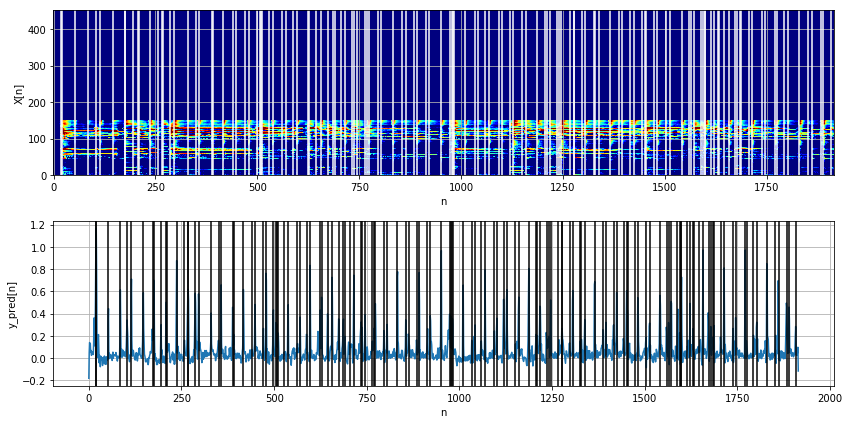

In [7]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 6))

ax0.imshow(X_train[0].T, origin='lower', vmin=0, vmax=1, aspect='auto')
ax0.set_xlabel('n')
ax0.set_ylabel('X[n]')
ax0.grid()
for target in Onset_times_train[0]:
    ax0.axvline(100*target, color='w')

if Y_pred_train[0].ndim > 1:
    ax1.plot(Y_pred_train[0][:, 0])
else:
    ax1.plot(Y_pred_train[0][:, 0])
ax1.set_xlabel('n')
ax1.set_ylabel('y_pred[n]')
ax1.grid()
for target in Onset_times_train[0]:
    ax1.axvline(100*target, color='k')

plt.tight_layout()